In [2]:
import json
from collections import defaultdict, Counter
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse
from sklearn.metrics import precision_recall_curve
from matplotlib.patches import Rectangle
import statsmodels.api as sm
import matplotlib
from itertools import compress

In [3]:
ped_file = '../../DATA/ssc/ssc.ped'
chroms = [str(x) for x in range(1, 23)]

assembly = '37'

In [4]:
colors=['#ef6c00ff', '#4db6acff', '#b3a77dff', '#695d46ff', '#ce93d8ff', '#009668ff', ]


In [5]:
ssc_old_id_to_new_id = dict()
with open('../data/ssc.id_map.from.repository', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        ssc_old_id_to_new_id[pieces[1]] = pieces[0]
        ssc_old_id_to_new_id[pieces[1].replace('.', '_')] = pieces[0]

In [6]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            if child_id in ssc_old_id_to_new_id and m_id in ssc_old_id_to_new_id and f_id in ssc_old_id_to_new_id:
                child_id = ssc_old_id_to_new_id[child_id]
                f_id = ssc_old_id_to_new_id[f_id]
                m_id = ssc_old_id_to_new_id[m_id]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

                if (fam_id, m_id, f_id) not in fam_to_inds:
                    fam_to_inds[(fam_id, m_id, f_id)] = [m_id, f_id]
                fam_to_inds[(fam_id, m_id, f_id)].append(child_id)
                
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 1037


# pull our deletions

In [7]:
# pull deletions
deletions = []
with open('../phased_ssc_del_qs/deletions.json') as f:
    for d in json.load(f):
        if d['is_inherited'] and not d['is_hts']:
            nodel_parent = d['mother'] if d['is_pat'] else d['father']
            for child in d['trans']:
                #if ('%s_num_markers_aCGH' % child) in d and ('%s_num_markers_aCGH' % nodel_parent) in d:
                deletions.append({
                                'family': d['family'],
                                'child': ssc_old_id_to_new_id[child],
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': ssc_old_id_to_new_id[d['mother']],
                                'father': ssc_old_id_to_new_id[d['father']],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo'],
                                #'num_markers': d['num_markers'],
                                'num_markers_aCGH': d.get('%s_num_markers_aCGH' % child, None),
                                'med_aCGH': d.get('%s_med_aCGH' % child, None),
                                'num_markers_aCGH_parent': d.get('%s_num_markers_aCGH' % nodel_parent, None),
                                'med_aCGH_parent': d.get('%s_med_aCGH' % nodel_parent, None),
                                'quality_score': None if 'quality_score' not in d else d['quality_score']
                        })
print(len(deletions))

105501


In [8]:
# pull deletions
hg002_deletions = []
with open('../phased_hg002_del_qs/deletions.json') as f:
    for d in json.load(f):
        if d['is_inherited'] and not d['is_hts'] and d['length']>1000:
            for child in d['trans']:
                if d['chrom'] in chroms:
                    hg002_deletions.append({
                                    'family': d['family'],
                                    'child': child,
                                    'chrom': d['chrom'],
                                    'start_pos': d['start_pos'],
                                    'end_pos': d['end_pos'],
                                    'length': d['length'],
                                    'opt_start_pos': d['opt_start_pos'],
                                    'opt_end_pos': d['opt_end_pos'],
                                    'is_mat': d['is_mat'],
                                    'is_pat': d['is_pat'],
                                    'mother': d['mother'],
                                    'father': d['father'],
                                    'is_inherited': d['is_inherited'],
                                    'is_denovo': d['is_denovo'],
                                    'quality_score': None if 'quality_score' not in d else d['quality_score']
                            })
print(len(hg002_deletions))

93


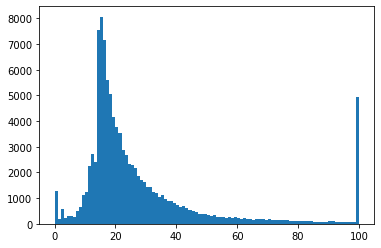

In [9]:
plt.hist(np.clip([d['quality_score'] for d in deletions if d['quality_score'] is not None], None, 100), 
         bins=np.arange(101))
plt.show()

In [10]:
#remove deletions that aren't inherited
deletions = [d for d in deletions if d['is_inherited']]
print('remaining deletions', len(deletions))


remaining deletions 105501


In [11]:
#remove deletions <100bp
deletions = [d for d in deletions if d['length']>=1000]
print('remaining deletions', len(deletions))


remaining deletions 71042


In [12]:
chrom_category_region_to_interval_starts, chrom_category_region_to_interval_ends = defaultdict(list), defaultdict(list)
regions = set()
with open('../data/filtered_regions_hg19.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        chrom, region_type = pieces[0][3:], pieces[3]
        if chrom in chroms:
            chrom_category_region_to_interval_starts[(chrom, 'filtered', region_type)].append(int(pieces[1])+1)
            chrom_category_region_to_interval_ends[(chrom, 'filtered', region_type)].append(int(pieces[2]))
            regions.add(region_type)
print(regions)
            
     
            
#with open('../data/microsat.txt', 'r') as f:
#    for line in f:
#        pieces = line.strip().split('\t')
#        if pieces[1][3:] in chroms:
#            chrom_to_interval_starts[pieces[1][3:]].append(int(pieces[2]))
#            chrom_to_interval_ends[pieces[1][3:]].append(int(pieces[3]))
#            chrom_to_region_types[pieces[1][3:]].append('STR')
#            
#with open('../../FamilySeqError/data/btu356-suppl_data/btu356_LCR-hs37d5.bed/btu356_LCR-hs37d5.bed', 'r') as f:
#    for line in f:
#        pieces = line.strip().split('\t')
#        if pieces[0] in chroms:
#            chrom_to_interval_starts[pieces[0]].append(int(pieces[1])+1)
#            chrom_to_interval_ends[pieces[0]].append(int(pieces[2]))
#            chrom_to_region_types[pieces[0]].append('LCR')

region_type_mapping = {
    'SINE': 'SINE',
    'LINE': 'LINE',
    'DNA': 'DNA',
    'LTR': 'LTR',
    'Low_complexity': 'Low_complexity',
    'Simple_repeat': 'STR',
    'Satellite': 'Other',
     'Unknown': 'Other',
    'snRNA': 'Other',
    'tRNA': 'Other',
    'DNA?': 'Other',
    'srpRNA': 'Other',
    'rRNA': 'Other',
    'RC': 'Other',
    'Other': 'Other',
    'SINE?': 'Other',
    'scRNA': 'Other',
    'RNA': 'Other',
    'LTR?': 'Other',
    'Unknown?': 'Other',
    'LINE?': 'Other',
   
}

regions = set()
with open('../data/hg19.fa.out', 'r') as f:
    next(f) # skip header
    next(f) # skip header
    next(f) # skip header
    for line in f:
        pieces = line.strip().split()
        chrom = pieces[4][3:]
        start_pos = int(pieces[5])
        end_pos = int(pieces[6])
        region_type = region_type_mapping[pieces[10].split('/')[0]]
        regions.add(region_type)
        
        if chrom in chroms:
            chrom_category_region_to_interval_starts[(chrom, 'repeat', region_type)].append(start_pos)
            chrom_category_region_to_interval_ends[(chrom, 'repeat', region_type)].append(end_pos)
print(regions)

{'segDup', 'centromere', 'TCR', 'unmapable', 'abparts'}
{'Other', 'LTR', 'DNA', 'LINE', 'Low_complexity', 'STR', 'SINE'}


In [13]:
with open('../data/hg19.trf.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        chrom = pieces[0][3:]
        start_pos = int(pieces[1])
        end_pos = int(pieces[2])
        
        chrom_category_region_to_interval_starts[(chrom, 'repeat', 'TRF')].append(start_pos)
        chrom_category_region_to_interval_ends[(chrom, 'repeat', 'TRF')].append(end_pos)
            
for key in chrom_category_region_to_interval_starts.keys():
    chrom_category_region_to_interval_starts[key] = np.array(chrom_category_region_to_interval_starts[key])
    chrom_category_region_to_interval_ends[key] = np.array(chrom_category_region_to_interval_ends[key])
    

In [14]:
regions_of_interest = [('repeat', 'SINE'),
                      ('repeat', 'LINE'),
                      ('repeat', 'DNA'),
                      ('repeat', 'LTR'),
                      ('repeat', 'STR'),
                      ('repeat', 'Low_complexity'),
                      ('repeat', 'Other'),
                      ('repeat', 'TRF'),
                      ('repeat', 'No_repeat'),
                      ('filtered', 'centromere'),
                      ('filtered', 'unmapable'),
                      ('filtered', 'segDup'),
                      ('filtered', 'abparts'),
                      ('filtered', 'TCR')]
region_to_index = dict([(x, i) for i, x in enumerate(regions_of_interest)])

is_region = np.zeros((len(deletions), len(regions_of_interest)), dtype=bool)


for chrom in chroms:
    print(chrom, end=' ')
    for (chrom, category, rt) in [x for x in chrom_category_region_to_interval_starts.keys() if x[0]==chrom]:
        
        starts, ends = chrom_category_region_to_interval_starts[(chrom, category, rt)], chrom_category_region_to_interval_ends[(chrom, category, rt)]
        if (category, rt) in region_to_index:
            print('%s.%s' % (category, rt), end=' ')
            region_index = region_to_index[(category, rt)]

            for i, d in [x for x in enumerate(deletions) if x[1]['chrom']==chrom]:
                overlaps = np.clip(np.minimum(d['end_pos'], ends) - np.maximum(d['start_pos'], starts), 0, None)
                if np.sum(overlaps)/d['length'] > 0.25:
                    is_region[i, region_index] = True
    print()

    
is_region[:, region_to_index[('repeat', 'STR')]] = is_region[:, region_to_index[('repeat', 'STR')]] | (is_region[:, region_to_index[('repeat', 'TRF')]] & \
            ~is_region[:, region_to_index[('repeat', 'SINE')]] & ~is_region[:, region_to_index[('repeat', 'LINE')]] & ~is_region[:, region_to_index[('repeat', 'DNA')]] & \
            ~is_region[:, region_to_index[('repeat', 'LTR')]] & ~is_region[:, region_to_index[('repeat', 'Low_complexity')]] & ~is_region[:, region_to_index[('repeat', 'Other')]])
is_region[:, region_to_index[('repeat', 'No_repeat')]] = ~is_region[:, region_to_index[('repeat', 'SINE')]] & ~is_region[:, region_to_index[('repeat', 'LINE')]] & ~is_region[:, region_to_index[('repeat', 'DNA')]] & \
            ~is_region[:, region_to_index[('repeat', 'LTR')]] & ~is_region[:, region_to_index[('repeat', 'Low_complexity')]] & ~is_region[:, region_to_index[('repeat', 'Other')]] & ~is_region[:, region_to_index[('repeat', 'STR')]]
      
for i, region in enumerate(regions_of_interest):
    print(region, np.sum(is_region[:, i]))
    


1 filtered.unmapable filtered.segDup filtered.centromere repeat.STR repeat.Other repeat.LINE repeat.DNA repeat.SINE repeat.LTR repeat.Low_complexity repeat.TRF 
2 filtered.unmapable filtered.segDup filtered.abparts filtered.centromere repeat.STR repeat.Other repeat.LTR repeat.SINE repeat.LINE repeat.DNA repeat.Low_complexity repeat.TRF 
3 filtered.unmapable filtered.segDup filtered.centromere repeat.DNA repeat.STR repeat.LINE repeat.Low_complexity repeat.SINE repeat.LTR repeat.Other repeat.TRF 
4 filtered.unmapable filtered.segDup filtered.centromere repeat.STR repeat.Other repeat.LTR repeat.SINE repeat.LINE repeat.DNA repeat.Low_complexity repeat.TRF 
5 filtered.unmapable filtered.segDup filtered.centromere repeat.STR repeat.Other repeat.LTR repeat.SINE repeat.LINE repeat.Low_complexity repeat.DNA repeat.TRF 
6 filtered.unmapable filtered.segDup filtered.centromere repeat.Low_complexity repeat.LTR repeat.SINE repeat.LINE repeat.STR repeat.DNA repeat.Other repeat.TRF 
7 filtered.unmapa

# validate with aCGH

In [15]:
num_markers = np.array([d['num_markers_aCGH'] for d in deletions])
has_acgh = np.array([(x is not None) and (x>2) for x in num_markers])
has_parent_acgh = np.array([d['med_aCGH_parent'] is not None for d in deletions])
acgh = np.log2([0 if d['med_aCGH'] is None else d['med_aCGH'] for d in deletions])
parent_acgh = np.log2([0 if d['med_aCGH_parent'] is None else d['med_aCGH_parent'] for d in deletions])

lengths = np.array([d['length'] for d in deletions])

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log2
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log2


In [40]:
print(deletions[0])

{'family': '14425', 'child': 'SSC11895', 'chrom': '5', 'start_pos': 19602, 'end_pos': 23025, 'length': 3424, 'opt_start_pos': 18537, 'opt_end_pos': 25328, 'is_mat': False, 'is_pat': True, 'mother': 'SSC11896', 'father': 'SSC11899', 'is_inherited': True, 'is_denovo': False, 'num_markers_aCGH': None, 'med_aCGH': None, 'num_markers_aCGH_parent': None, 'med_aCGH_parent': None, 'quality_score': 14.816356}


In [43]:
print(len(set([deletions[i]['child'] for i in np.where(has_acgh)[0]]) | \
          set([deletions[i]['mother'] if deletions[i]['is_mat'] else deletions[i]['father'] for i in np.where(has_parent_acgh)[0]])))
      
      

628


In [16]:
print(np.sum(has_acgh)/np.sum([x is not None for x in num_markers]))

0.5462622402674946


In [17]:
print(np.sum(has_acgh & (acgh<-0.25))/np.sum(has_acgh))
print(np.sum(has_acgh & (acgh-parent_acgh<-0.3))/np.sum(has_acgh))
print(np.sum(has_acgh & (acgh>-0.25) & (acgh-parent_acgh<-0.25))/np.sum(has_acgh))

print(np.sum(has_acgh & ((acgh<-0.25) | (acgh-parent_acgh<-0.25)))/np.sum(has_acgh))

is_val_acgh = has_acgh & ((acgh<-0.25) | (acgh-parent_acgh<-0.25))

0.6720006995452955
0.7372332983560685
0.18249387897866387
0.8544945785239594


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encounter

In [18]:
print(2**-0.25)

0.8408964152537145


In [19]:
#sebat_acgh = np.log2([d['med_aCGH'] for d in sebat_deletions])
                             

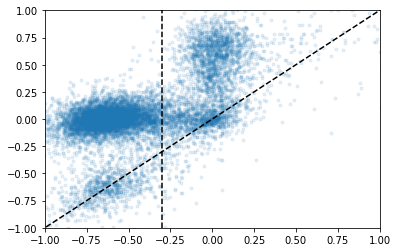

In [20]:
plt.scatter(acgh[has_acgh & has_parent_acgh],
            parent_acgh[has_acgh & has_parent_acgh],
            alpha=0.1, marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axvline(-0.3, color='black', linestyle='--')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()

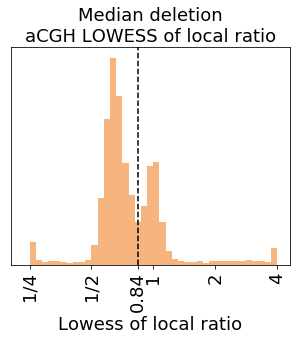

In [39]:
#matplotlib.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(5, 4))
#plt.hist(np.clip(sebat_acgh[sebat_has_acgh & ~is_sebat_excluded], -2, 2), 
#         alpha=0.5, bins=np.arange(-2.1, 2.1, 0.1), color=colors[1], label='Brandler 2018', density=True)
plt.hist(np.clip(acgh[has_acgh], -2, 2), 
         alpha=0.5, bins=np.arange(-2.1, 2.1, 0.1), color=colors[0], label='Family-based method', density=True)

plt.axvline(-0.25, color='black', linestyle='--')
#plt.axvline(-0.66, color='black', linestyle='--')
#plt.legend()
plt.xlabel('Lowess of local ratio', fontsize=18)
plt.title('Median deletion\naCGH LOWESS of local ratio', fontsize=18)
plt.xticks([-2, -1, -0.25, 0, 1, 2], ['1/4', '1/2', '0.84', '1', '2', '4'], rotation=90, fontsize=18)
plt.yticks([])
#plt.ylabel('Distribution of deletions')
#plt.show()
fig.savefig('../plots/med_acgh.png', dpi=fig.dpi)

In [22]:
print(2**-0.66)
print(2**-0.25)
print(2**0)

0.63287829698514
0.8408964152537145
1


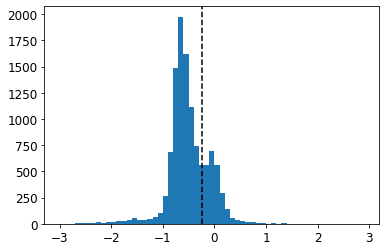

In [23]:
plt.hist(acgh[has_acgh & has_parent_acgh]-parent_acgh[has_acgh & has_parent_acgh], bins=np.arange(-3, 3, 0.1))
plt.axvline(-0.25, color='black', linestyle='--')
plt.show()

In [57]:
print(len(set([]np.sum(has_acgh))

11436


In [58]:
2**-0.25


0.8408964152537145

In [46]:
print(np.sum(has_acgh)/np.sum(np.array([x is not None for x in num_markers])))

0.5462622402674946


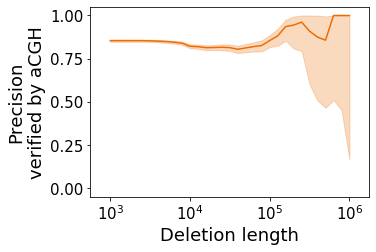

In [50]:
fig = plt.figure(figsize=(5, 3.5))

#plt.subplot(1, 2, 1)
#plt.hist([np.log10(lengths[has_acgh]), 
#          np.log10(lengths[~has_acgh & np.array([x is not None for x in num_markers])])],
#          bins=np.arange(3, 6.25, 0.25), color=[colors[0], colors[1]], label='Our method', stacked=True)
#handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in [colors[0], colors[1]]]
#labels= [">2 aCGH probes","<=2 aCGH probes"]
#plt.legend(handles, labels, fontsize=15)
#plt.xticks(np.arange(3, 7), ['$10^{%d}$' % x for x in np.arange(3, 7)], fontsize=15)
#plt.yticks([])
#plt.xlabel('Deletion length', fontsize=18)

#plt.subplot(1, 2, 2)

bins = np.arange(3, 6.1, 0.1).tolist()

percent_val = np.zeros((len(bins),))
percent_val_ub, percent_val_lb = np.zeros((len(bins),)), np.zeros((len(bins),))
#plt.xticks(np.arange(2, 7), ['$10^{%d}$' % x for x in np.arange(2, 7)])

for i, j in enumerate(bins):
    x = np.sum((np.log10(lengths)>=j) & has_acgh & is_val_acgh)
    n = np.sum((np.log10(lengths)>=j) & has_acgh)
    percent_val[i] = x/n
    percent_val_ub[i], percent_val_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')

plt.plot(bins, percent_val, label='Family-based method', color=colors[0])
plt.fill_between(bins, percent_val_ub, percent_val_lb, color=colors[0], alpha=0.25)

plt.xlabel('Deletion length', fontsize=18)
plt.ylabel('Precision\nverified by aCGH', fontsize=18)
plt.ylim([-0.05, 1.05])
plt.xticks(np.arange(3, 7), ['$10^{%d}$' % x for x in np.arange(3, 7)], fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([2.75, 6.25])
#plt.tight_layout()




#plt.show()
fig.savefig('../plots/acgh_val.png', dpi=fig.dpi)

In [22]:
def get_confint(x, n):
    val = x/n
    lb, ub = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')
    return val, ub, lb

In [23]:
overall_precision = np.sum(is_val_acgh)/np.sum(has_acgh)

[1078. 5248.   66. 1114.   18.] [1296. 6062.   72. 1333.   26.]
[ 261.  825. 1011.   36.   29.] [ 293. 1388. 1688.   44.   50.]


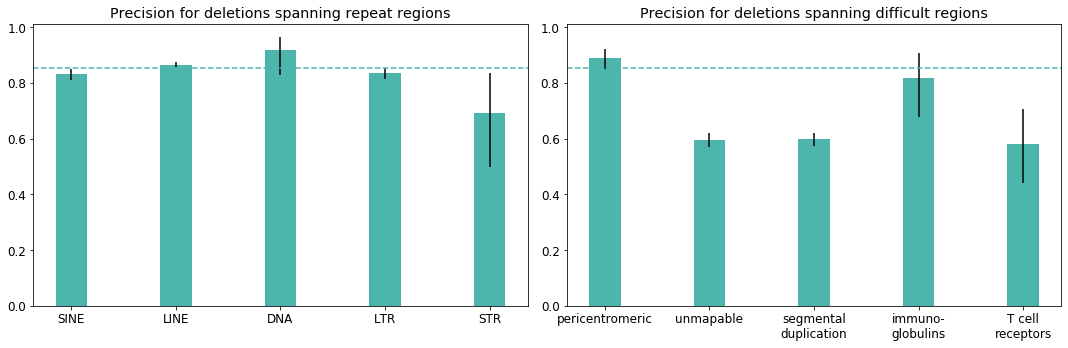

In [24]:
fig = plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)

keys = ['SINE', 'LINE', 'DNA', 'LTR', 'STR']
precision_x, precision_n = np.zeros((len(keys),)), np.zeros((len(keys),))

for i, key in enumerate(keys):
    precision_x[i] = np.sum(has_acgh & is_region[:, region_to_index[('repeat', key)]] & is_val_acgh)
    precision_n[i] = np.sum(has_acgh & is_region[:, region_to_index[('repeat', key)]])

print(precision_x, precision_n)    
precision, precision_ub, precision_lb = get_confint(precision_x, precision_n)


plt.bar(np.arange(len(keys)), precision, yerr=(precision-precision_lb, precision_ub-precision), 
        width=0.3, label='precision', color=colors[1])
plt.axhline(overall_precision, linestyle='--', color=colors[1])

plt.xticks(np.arange(len(keys)), keys)
plt.title('Precision for deletions spanning repeat regions')
#plt.xlabel('Repeat Type')
#plt.ylim(-0.1, 1.1)

plt.subplot(1, 2, 2, sharey=ax)

keys = ['centromere', 'unmapable', 'segDup', 'abparts', 'TCR']
precision_x, precision_n = np.zeros((len(keys),)), np.zeros((len(keys),))

for i, key in enumerate(keys):
    precision_x[i] = np.sum(has_acgh & is_region[:, region_to_index[('filtered', key)]] & is_val_acgh)
    precision_n[i] = np.sum(has_acgh & is_region[:, region_to_index[('filtered', key)]])


print(precision_x, precision_n)
precision, precision_ub, precision_lb = get_confint(precision_x, precision_n)

plt.bar(np.arange(len(keys)), precision, yerr=(precision-precision_lb, precision_ub-precision), 
        width=0.3, label='precision', color=colors[1])

plt.axhline(overall_precision, linestyle='--', color=colors[1])

#plt.xticks(np.arange(len(keys)), keys)
plt.xticks(np.arange(len(keys)), ['pericentromeric', 'unmapable', 'segmental\nduplication', 'immuno-\nglobulins', 'T cell\nreceptors'])
plt.title('Precision for deletions spanning difficult regions')
#plt.legend()
#plt.ylim(None, 1.1)

#plt.show()
plt.tight_layout()
fig.savefig('../plots/hard-to-sequence.png', dpi=fig.dpi)



In [25]:
print(is_region[:, region_to_index[('filtered', 'abparts')]].shape, len(deletions))

(71042,) 71042


In [26]:
print(stats.binom_test([len([x for x in compress(deletions, is_region[:, region_to_index[('filtered', 'abparts')]]) if child_id_to_affected[x['child']]=='2']),
      len([x for x in compress(deletions, is_region[:, region_to_index[('filtered', 'abparts')]]) if child_id_to_affected[x['child']]=='1'])]))

print(stats.binom_test([len([x for x in compress(deletions, is_region[:, region_to_index[('filtered', 'centromere')]]) if child_id_to_affected[x['child']]=='2']),
      len([x for x in compress(deletions, is_region[:, region_to_index[('filtered', 'centromere')]]) if child_id_to_affected[x['child']]=='1'])]))

print(stats.binom_test([len([x for x in compress(deletions, is_region[:, region_to_index[('filtered', 'segDup')]]) if child_id_to_affected[x['child']]=='2']),
      len([x for x in compress(deletions, is_region[:, region_to_index[('filtered', 'segDup')]]) if child_id_to_affected[x['child']]=='1'])]))

print(stats.binom_test([len([x for x in compress(deletions, is_region[:, region_to_index[('filtered', 'TCR')]]) if child_id_to_affected[x['child']]=='2']),
      len([x for x in compress(deletions, is_region[:, region_to_index[('filtered', 'TCR')]]) if child_id_to_affected[x['child']]=='1'])]))
     
print(stats.binom_test([len([x for x in compress(deletions, is_region[:, region_to_index[('filtered', 'unmapable')]]) if child_id_to_affected[x['child']]=='2']),
      len([x for x in compress(deletions, is_region[:, region_to_index[('filtered', 'unmapable')]]) if child_id_to_affected[x['child']]=='1'])]))
          
print(stats.binom_test([len([x for x in compress(deletions, is_region[:, region_to_index[('repeat', 'STR')]]) if child_id_to_affected[x['child']]=='2']),
      len([x for x in compress(deletions, is_region[:, region_to_index[('repeat', 'STR')]]) if child_id_to_affected[x['child']]=='1'])]))
     

1.0
0.9575404081317384
0.659872917574238
0.8107908223963681
0.6423751469974519
0.7838182300755075


# Deletion profile

In [27]:

with open('../phased_ssc_del_qs/families.json') as f:
    families = json.load(f)
    
families.remove('12412') # missing data 
    
family_to_index = dict([(x, i) for i, x in enumerate(families)])

In [28]:
print(len(set([x['family'] for x in deletions if 'num_markers_aCGH' in x and x['num_markers_aCGH'] is not None])))

159


In [29]:
print(len(families))

518


In [30]:
keys = ['centromere', 'unmapable', 'segDup', 'abparts', 'TCR']
is_hts = np.zeros((len(deletions),), dtype=bool)
for i, key in enumerate(keys):
    is_hts = is_hts | is_region[:, region_to_index[('filtered', key)]]

print(np.sum(is_hts)/len(is_hts))

0.2777793417978097


In [31]:
# family, mat/pat, unaff/aff
dels_per_child = np.zeros((len(families), 2, 2), dtype=int)
bp_per_child = np.zeros((len(families), 2, 2), dtype=int)

bp_per_child_not_hts = np.zeros((len(families), 2, 2), dtype=int)

# family, unaff/aff
family_to_sex = np.zeros((len(families), 2), dtype=int)
           
for i, d in enumerate(deletions):
    if d['family'] in family_to_index:
        dels_per_child[family_to_index[d['family']], int(d['is_pat']), int(child_id_to_affected[d['child']]=='2')] += 1
        bp_per_child[family_to_index[d['family']], int(d['is_pat']), int(child_id_to_affected[d['child']]=='2')] += d['length']
        
        if not is_hts[i]:
            bp_per_child_not_hts[family_to_index[d['family']], int(d['is_pat']), int(child_id_to_affected[d['child']]=='2')] += d['length']

        family_to_sex[family_to_index[d['family']], int(child_id_to_affected[d['child']]=='2')] = int(child_id_to_sex[d['child']]=='1')



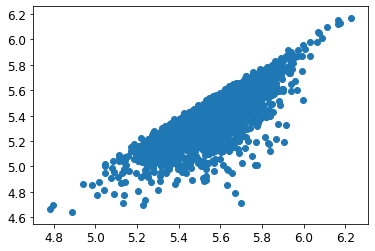

In [32]:
plt.scatter(np.log10(bp_per_child), np.log10(bp_per_child_not_hts))

In [33]:
mat_lengths = np.array([d['length'] for d in deletions if d['is_mat']])
pat_lengths = np.array([d['length'] for d in deletions if d['is_pat']])


mat median 396312.5
pat median 373428.5


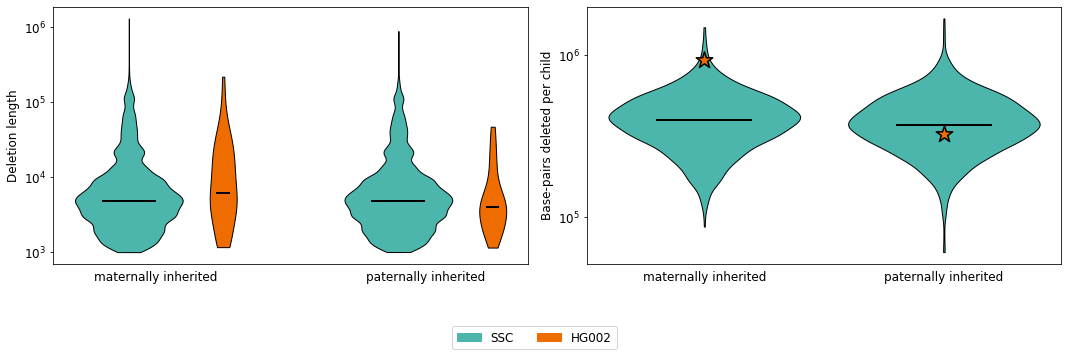

In [34]:
fig = plt.figure(figsize=(15, 5))

bins = np.arange(3, 5.5, 0.1)


ax = plt.subplot(1, 2, 1)
parts = plt.violinplot(
                    [np.log10(mat_lengths), np.log10([d['length'] for d in hg002_deletions if d['is_mat']]),
                     np.log10(pat_lengths), np.log10([d['length'] for d in hg002_deletions if d['is_pat']])], 
                [0, 0.7, 2, 2.7],
                showmedians=True, showextrema=False, widths=[0.8, 0.2, 0.8, 0.2])
#hg002_parts = plt.violinplot([np.log10([d['length'] for d in hg002_deletions if d['is_mat']]),
#                np.log10([d['length'] for d in hg002_deletions if d['is_pat']])], 
#                showmedians=True, showextrema=False, widths=0.1)
plt.ylabel('Deletion length')

for i in range(4):
    if i%2==0:
        parts['bodies'][i].set_facecolor(colors[1])
    else:
        parts['bodies'][i].set_facecolor(colors[0])
    parts['bodies'][i].set_edgecolor('black')
    parts['bodies'][i].set_alpha(1)

parts['cmedians'].set_edgecolor('black')
parts['cmedians'].set_linewidth(2)

#hg002_parts['bodies'][0].set_facecolor(colors[0])
#hg002_parts['bodies'][0].set_edgecolor('black')
#hg002_parts['bodies'][0].set_alpha(1)
#hg002_parts['bodies'][1].set_facecolor(colors[0])
#hg002_parts['bodies'][1].set_edgecolor('black')
#hg002_parts['bodies'][1].set_alpha(1)
#hg002_parts['cmedians'].set_edgecolor('black')
#hg002_parts['cmedians'].set_linewidth(2)

plt.yticks(np.log10([10**3, 10**4, 10**5, 10**6]), ['$10^3$', '$10^4$', '$10^5$', '$10^6$'])
plt.xticks([0.2, 2.2], ['maternally inherited', 'paternally inherited'])
plt.tick_params(bottom=False)
bins = np.arange(5, 6.5, 0.1)


plt.subplot(1, 2, 2)
print('mat median', np.median(np.hstack((bp_per_child[:, 0, 0], bp_per_child[:, 0, 1]))))
print('pat median', np.median(np.hstack((bp_per_child[:, 1, 0], bp_per_child[:, 1, 1]))))
parts = plt.violinplot([np.log10(np.hstack((bp_per_child[:, 0, 0], bp_per_child[:, 0, 1]))), 
                        np.log10(np.hstack((bp_per_child[:, 1, 0], bp_per_child[:, 1, 1])))],
              showmedians=True, showextrema=False, widths=0.8)
#parts = plt.violinplot([np.log10(bp_per_child[:, 0, 0]), np.log10(bp_per_child[:, 0, 1]), 
#                        np.log10(bp_per_child[:, 1, 0]), np.log10(bp_per_child[:, 1, 1])],
#              showmedians=True, showextrema=False, widths=0.8)
plt.ylabel('Base-pairs deleted per child')
plt.yticks(np.log10([10**5, 10**6, 10**7]), ['$10^5$', '$10^6$', '$10^7$'])
plt.xticks([1, 2], ['maternally inherited', 'paternally inherited'])
parts['bodies'][0].set_facecolor(colors[1])
parts['bodies'][0].set_edgecolor('black')
parts['bodies'][0].set_alpha(1)
parts['bodies'][1].set_facecolor(colors[1])
parts['bodies'][1].set_edgecolor('black')
parts['bodies'][1].set_alpha(1)
parts['cmedians'].set_edgecolor('black')
parts['cmedians'].set_linewidth(2)

plt.fill_between([2, 2], [5, 5], [5, 5], color=colors[1], label='SSC')
plt.fill_between([2, 2], [5, 5], [5, 5], color=colors[0], label='HG002')
plt.scatter([1, 2], [np.log10(np.sum([d['length'] for d in hg002_deletions if d['is_mat']])), 
                     np.log10(np.sum([d['length'] for d in hg002_deletions if d['is_pat']]))], 
                     marker='*', facecolor=colors[0], s=300, linewidth=1.5, edgecolor='black')

plt.tick_params(bottom=False)

fig.legend(ncol=2, loc='lower center')
fig.tight_layout()
fig.subplots_adjust(bottom=0.25) 

fig.savefig('../plots/deletion_summary.png', dpi=fig.dpi)
#plt.show()



In [35]:
print(len(deletions))
print(np.median(np.hstack((mat_lengths, pat_lengths))))

71042
4812.0


In [36]:
keys = sorted(bp_per_child_pat.keys())
print(stats.ttest_ind(np.log10(mat_lengths),
                      np.log10(pat_lengths)))

print('aut get more than nt?', stats.ttest_rel(np.log10(np.sum(bp_per_child[:, :, 0], axis=1)),
                      np.log10(np.sum(bp_per_child[:, :, 1], axis=1))))
print('aut get more mat than nt?', stats.ttest_rel(np.log10(bp_per_child[:, 0, 1]),
                      np.log10(bp_per_child[:, 0, 0])))
print('aut get more pat than nt?', stats.ttest_rel(np.log10(bp_per_child[:, 1, 1]),
                      np.log10(bp_per_child[:, 1, 0])))

print('mat more than pat?', stats.ttest_rel(np.log10(np.hstack((bp_per_child[:, 0, 0], bp_per_child[:, 0, 1]))),
                      np.log10(np.hstack((bp_per_child[:, 1, 0], bp_per_child[:, 1, 1])))))
print('mat more than pat for aut?', stats.ttest_rel(np.log10(bp_per_child[:, 0, 1]),
                      np.log10(bp_per_child[:, 1, 1])))
print('mat more than pat for nt?', stats.ttest_rel(np.log10(bp_per_child[:, 0, 0]),
                      np.log10(bp_per_child[:, 1, 0])))




NameError: name 'bp_per_child_pat' is not defined

In [ ]:
print(stats.pearsonr(np.log10(np.hstack((bp_per_child[:, 0, 0], bp_per_child[:, 0, 1]))),
            np.log10(np.hstack((bp_per_child[:, 1, 0], bp_per_child[:, 1, 1])))))
plt.scatter(np.log10(np.hstack((bp_per_child[:, 0, 0], bp_per_child[:, 0, 1]))),
            np.log10(np.hstack((bp_per_child[:, 1, 0], bp_per_child[:, 1, 1]))))
plt.show()